In [1]:
import copy

import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

import explore_heuristic

k means 2D boundaries determine which cluster you belong to will be straight lines, so does that imply that the data is linearly separable?

Step1:
 - assuming we query and that cluster centers dont change, what do we find 


Step2: adding points can change outcome 
 - start with dataset, learn k means, try d+s and learn k means, how do cluster centers differ
 - empirical: real data, insert fake data, how much does cluster center move
 - theoretical: 

In [2]:
data = pd.read_csv('loc-brightkite_totalCheckins.txt', sep='\t', names=['zero', 'time', 'latitude', 'longitude', 'location id'])

In [3]:
def ground_truth_kmeans(full_data):
    # Initialize and fit the K-Means model
    temp_kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    temp_kmeans.fit(full_data)

    return temp_kmeans

In [4]:
def random_subsample(full_data, num_samples):
    """Return a random subset of N samples from all the data."""
    perm = np.random.permutation(full_data.shape[0])
    less_data = copy.deepcopy(full_data[perm][:num_samples])
    return less_data

In [5]:
# Filter for relevant columns and drop any rows with missing latitude or longitude
location_data = data[['latitude', 'longitude']].dropna()

# Number of clusters - adjust based on your goal
num_clusters = 10

# Constant for subsample size
subsample_size = 1000

location_data_array = location_data[['latitude', 'longitude']].to_numpy()

all_locations_k_means = ground_truth_kmeans(location_data_array)

subsample_data_array = random_subsample(location_data_array, subsample_size)
subsample_k_means = ground_truth_kmeans(
    subsample_data_array
)


/Users/beneyre/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/beneyre/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [6]:
def create_prediction_plot(query_set, labels, centers=None, title=None):
    """Create a 2D plot of the data, coloured according to predictions."""
    
    print(query_set.shape)
    print(labels.shape)
    print(len(np.unique(labels)))
    
    # Create the plot
    plt.figure(figsize=(10, 8))
    plt.scatter(query_set[:, 1], query_set[:, 0], 
                c=labels, cmap='viridis', s=10)
    if centers is not None:
        plt.scatter(centers[:, 1], centers[:, 0], 
                    c="red", s=30, marker="*"
                   )
    plt.colorbar(label='Predicted Cluster')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    if title is None:
        plt.title(f'K-Means Clustering of Brightkite Check-ins with {num_clusters} Clusters')
    else:
        plt.title(title)
    plt.show()
    plt.clf()
    

In [7]:
def train_log_regressor(train_data, labels):    
    # Train a multiclass logistic regression model
    classif = LogisticRegression(multi_class='multinomial', max_iter=1000)
    classif.fit(train_data, labels)
    return classif

(1000, 2)
(1000,)
10


/Users/beneyre/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


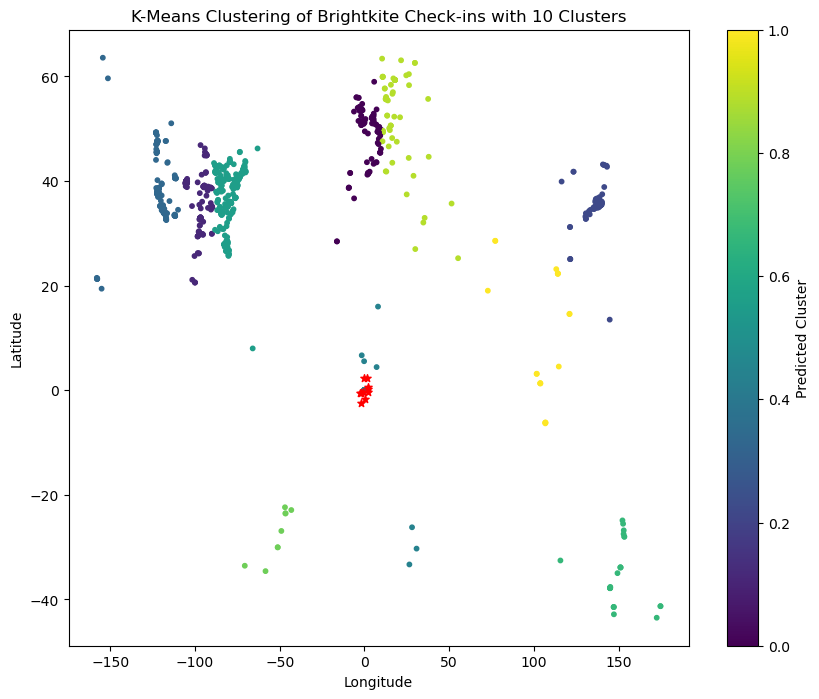

<Figure size 640x480 with 0 Axes>

In [8]:
classifier = train_log_regressor(subsample_data_array, subsample_k_means.labels_)
# Create the predictions
classif_labels = classifier.predict(subsample_data_array)
create_prediction_plot(
    subsample_data_array, classif_labels, centers=classifier.coef_
)

(4747281, 2)
(4747281,)
10


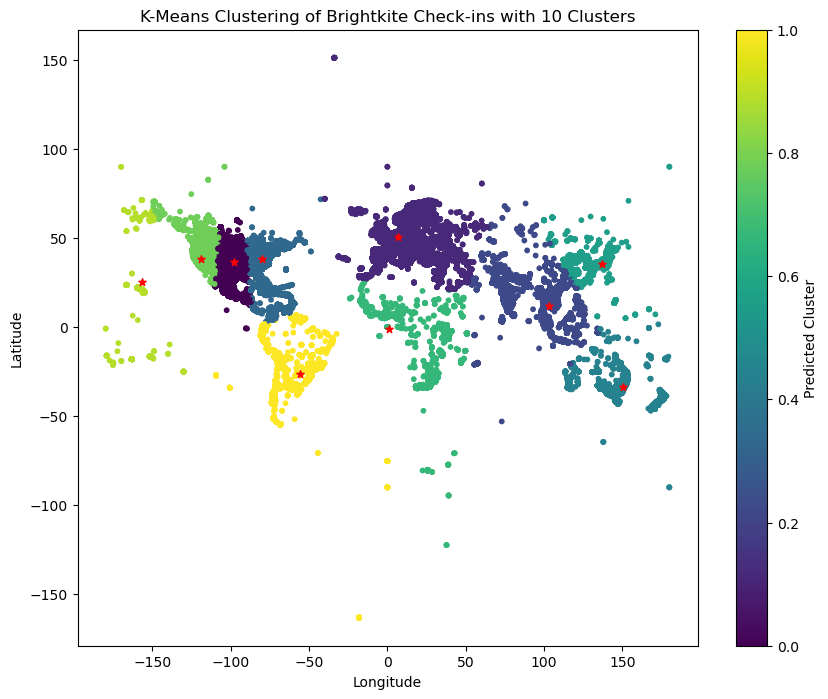

<Figure size 640x480 with 0 Axes>

In [9]:
create_prediction_plot(
    location_data_array, all_locations_k_means.labels_, centers=all_locations_k_means.cluster_centers_
)

(1000, 2)
(1000,)
10


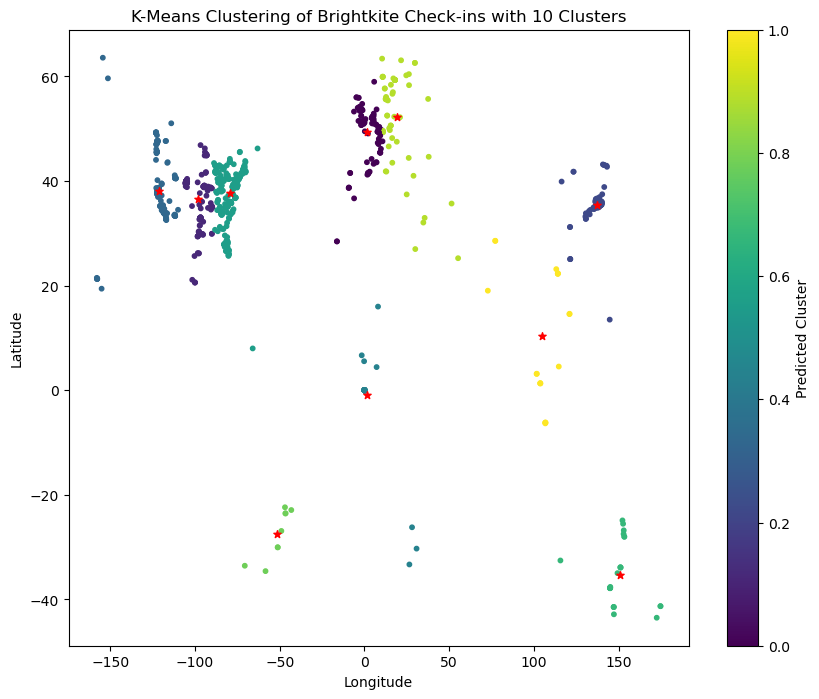

<Figure size 640x480 with 0 Axes>

In [10]:
create_prediction_plot(
    subsample_data_array, subsample_k_means.labels_, centers=subsample_k_means.cluster_centers_
)

In [11]:
def generate_new_cluster_labels(original_data, num_new_samples, bounds,
                                method="random", retraining="online",
                                old_kmeans=None, old_samples=None, epsilon=0.5):
    """Sample some data by re-training k-means with the new data.
    
    Parameters:
        original_data: numpy array. The base data that is hidden.
        num_new_samples: int. The number of new samples to create.
        bounds: numpy array. Dx2 array of lower and upper bounds for
            each feature.
        method: string. How we'll create the new data.
            "random": Randomly sample points from the space.
            "distance": Sample points perpetually further away from other points.
        retraining: string. How we'll create the new clusters.
            "online": Start from a previously learned set of centers.
            "restart": Start from scratch with the same random init.
        old_kmeans: sklearn KMeans object or None. Another KMeans object.
            Used to extract the old cluster centres for "online"
            or to predict with "query".
        old_samples: numpy array or None. Previously created centres
            to use when the sample method is "distance".
        epsilon: float. If "distance" is the method, the min distance to exceed.
            
    Return: numpy array, numpy array {KMeans object, None}.
        Nx2 array of data, N-dimensional vector of labels.
        May return a KMeans object if "online".
    
    """
    if method == "random":
        # Sample uniformly within the bounds.
        features = []
        for bound_idx in range(bounds.shape[0]):
            features.append(
                np.random.uniform(bounds[bound_idx, 0], bounds[bound_idx, 1], num_new_samples)
            )
        # Turn this into one array.
        new_samps = np.stack(features)
        new_samps = new_samps.transpose()
    elif method == "distance":
        new_samps = explore_heuristic.explore_heuristic(
            num_new_samples, bounds, old_samples, epsilon=epsilon
        )
    else:
        raise NotImplementedError("No other methods.")
    
    # Add the new samples to the original array and retrain kmeans.
    all_samples = np.concatenate((original_data, new_samps))
    
    # Initialize k-means according to which retraining paradigm
    # we will be working with.
    if retraining == "online":
        assert old_kmeans is not None
        kmeans = KMeans(n_clusters=num_clusters, random_state=0, init=old_kmeans.cluster_centers_, n_init=1)
    elif retraining == "restart":
        kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    elif retraining == "query":
        kmeans = copy.deepcopy(old_kmeans)
    

    if retraining == "query":
        new_samp_labels = kmeans.predict(new_samps)
    else:
        kmeans.fit(all_samples)

        # Extract the new labels and return.
        new_samp_labels = kmeans.labels_[-num_new_samples:]
    
    if retraining == "online":
        return new_samps, new_samp_labels, kmeans
    else:
        return new_samps, new_samp_labels
    

In [12]:
def determine_bounds(input_array):
    bounds = []
    for dim_idx in range(input_array.shape[1]):
        bounds.append(np.array([
            np.min(input_array[:, dim_idx]), np.max(input_array[:, dim_idx])
        ]))
    all_bounds = np.stack(bounds)
    return all_bounds

[[ -43.494513   63.588753]
 [-158.028771  174.776639]]
(1000, 2)
(1000,)
10


/Users/beneyre/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


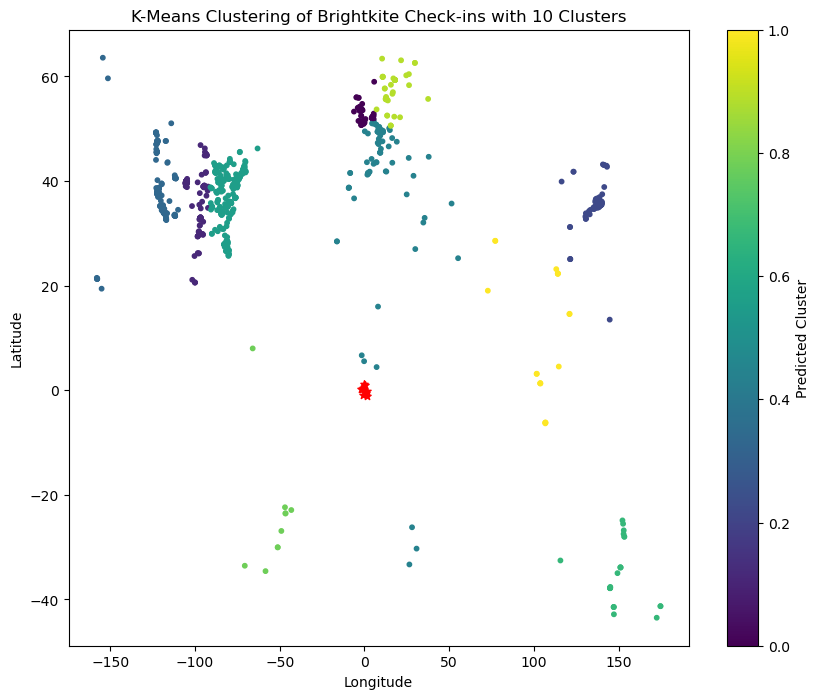

<Figure size 640x480 with 0 Axes>

In [13]:
bounds = determine_bounds(subsample_data_array)
print(bounds)
unif_new_samps, unif_new_labels = generate_new_cluster_labels(
    subsample_data_array, int(subsample_size/10), bounds, method="random", retraining="query",
    old_kmeans=subsample_k_means
)
unif_classifier = train_log_regressor(unif_new_samps, unif_new_labels)
# Create the predictions on the ORIGINAL data
unif_classif_labels = unif_classifier.predict(subsample_data_array)
create_prediction_plot(
    subsample_data_array, unif_classif_labels, centers=unif_classifier.coef_
)

In [14]:
import warnings
from sklearn.exceptions import ConvergenceWarning

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    bounds = determine_bounds(subsample_data_array)
    print(bounds)
    online_acc_list = []
    for repeat in range(1):
        online_new_data = []
        online_new_labels = []
        # Copy the kmeans object as we'll be overwriting
        # this for the online learning.
        new_kmeans = copy.deepcopy(subsample_k_means)
        for iteration in range(2):
            re_new_samps, re_new_labels, new_kmeans = generate_new_cluster_labels(
                subsample_data_array, 50, bounds, method="random", retraining="online",
                old_kmeans=new_kmeans
            )
            online_new_data.append(re_new_samps)
            online_new_labels.append(re_new_labels)

        online_new_data = np.concatenate(online_new_data)
        online_new_labels = np.concatenate(online_new_labels)
        online_classifier = train_log_regressor(online_new_data, online_new_labels)
    #     # Create the predictions on the ORIGINAL data
    #     online_classif_labels = online_classifier.predict(subsample_data_array)
    #     create_prediction_plot(
    #         subsample_data_array, online_classif_labels, centers=online_classifier.coef_
    #     )

        online_acc = sklearn.metrics.accuracy_score(
            subsample_k_means.labels_, online_classifier.predict(subsample_data_array)
        )
        online_acc_list.append(online_acc)

    print("Mean accuracy {}".format(np.mean(online_acc_list)))
    print("Std accuracy {}".format(np.std(online_acc_list)))

[[ -43.494513   63.588753]
 [-158.028771  174.776639]]
Mean accuracy 0.887
Std accuracy 0.0


(100, 2)
(100,)
10


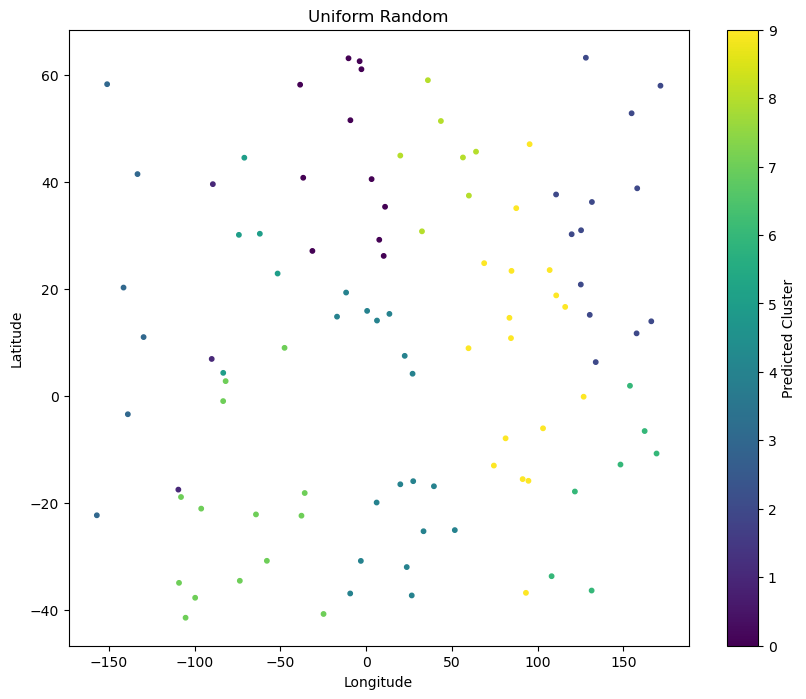

<Figure size 640x480 with 0 Axes>

In [15]:
create_prediction_plot(
    online_new_data, online_new_labels, title="Uniform Random"
)

In [16]:
# Compare accuracies for the models trained with different sampling methods.

# NOTE: This comparison doesn't really make sense, as
# the labels from different instances of KMeans are not transferrable between
# each other.
location_data_array, all_locations_k_means.labels_
unif_acc = sklearn.metrics.accuracy_score(
    all_locations_k_means.labels_, unif_classifier.predict(location_data_array)
)
online_acc = sklearn.metrics.accuracy_score(
    all_locations_k_means.labels_, online_classifier.predict(location_data_array)
)

base_acc = sklearn.metrics.accuracy_score(
    all_locations_k_means.labels_, classifier.predict(location_data_array)
)

print("Query acc: {}".format(unif_acc))
print("Online acc: {}".format(online_acc))
print("Base acc: {}".format(base_acc))

Query acc: 2.106468945065607e-06
Online acc: 0.0003231323361730641
Base acc: 0.0006260425704734985


In [17]:
from importlib import reload 
reload(explore_heuristic)

dist_acc_list = []

import warnings
from sklearn.exceptions import ConvergenceWarning

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)

    for repeat in range(1):
        bounds = determine_bounds(subsample_data_array)
        distance_new_data = []
        distance_new_labels = []
        # Copy the kmeans object as we'll be overwriting
        # this for the online learning.
        new_kmeans = copy.deepcopy(subsample_k_means)
        for iteration in range(2):
            if len(distance_new_data) == 0:
                old_samps = None
            else:
                old_samps = np.concatenate(distance_new_data)
            re_new_samps, re_new_labels, new_kmeans = generate_new_cluster_labels(
                subsample_data_array, 50, bounds, method="distance", retraining="online",
                old_kmeans=new_kmeans, old_samples=old_samps, epsilon=15.0
            )
            distance_new_data.append(re_new_samps)
            distance_new_labels.append(re_new_labels)

        distance_new_data = np.concatenate(distance_new_data)
        distance_new_labels = np.concatenate(distance_new_labels)
        distance_classifier = train_log_regressor(distance_new_data, distance_new_labels)
    #     # Create the predictions on the ORIGINAL data
    #     distance_classif_labels = distance_classifier.predict(subsample_data_array)
    #     create_prediction_plot(
    #         subsample_data_array, distance_classif_labels, centers=distance_classifier.coef_
    #     )

        distance_acc = sklearn.metrics.accuracy_score(
            subsample_k_means.labels_, distance_classifier.predict(subsample_data_array)
        )
        dist_acc_list.append(distance_acc)

    print("Mean accuracy {}".format(np.mean(dist_acc_list)))
    print("Std accuracy {}".format(np.std(dist_acc_list)))

Mean accuracy 0.915
Std accuracy 0.0


(100, 2)
(100,)
10


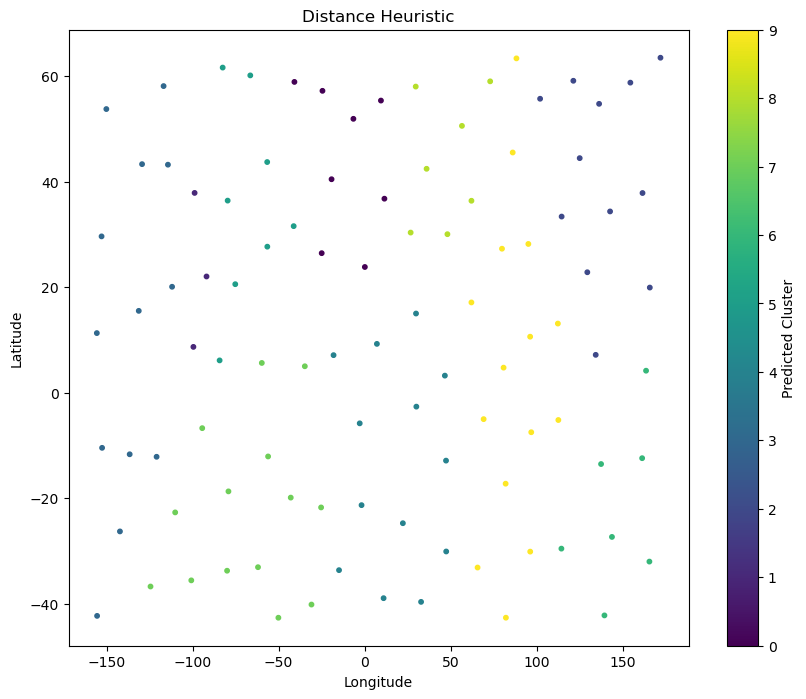

<Figure size 640x480 with 0 Axes>

In [18]:
create_prediction_plot(
    distance_new_data, distance_new_labels, title="Distance Heuristic"
)

In [19]:
# Compare accuracies for the models trained with different sampling methods.
location_data_array, all_locations_k_means.labels_
unif_acc = sklearn.metrics.accuracy_score(
    subsample_k_means.labels_, unif_classifier.predict(subsample_data_array)
)
online_acc = sklearn.metrics.accuracy_score(
    subsample_k_means.labels_, online_classifier.predict(subsample_data_array)
)

distance_acc = sklearn.metrics.accuracy_score(
    subsample_k_means.labels_, distance_classifier.predict(subsample_data_array)
)

base_acc = sklearn.metrics.accuracy_score(
    subsample_k_means.labels_, classifier.predict(subsample_data_array)
)

print("Query acc: {}".format(unif_acc))
print("Online acc: {}".format(online_acc))
print("Distance acc: {}".format(distance_acc))
print("Base acc: {}".format(base_acc))

Query acc: 0.922
Online acc: 0.887
Distance acc: 0.915
Base acc: 0.999


do this with graphs at each x interations to see how decision boundaries converge 

k means with adding points to change environment

sample uniformly, do SGD, how good is that? Next, can this motivate how labels are changing and the heuristic for picking points 

active learning, voronoi diagrams 

theoretical yields. multiclass classification. rates of convergence etcetera. 

every query, rerun k means.... noisy labels? how do we query points, how do decide the number of points to query, active learning 

set nuber of query points. can move them around at each step, only allowed to move them by a given amount. Where do you move them? Send points towards different decision boundaries 

OR: we can put points where we want every single but, but k means is retrained on gaussians centererd at original data points. so our underlying data is shifting,,, how do we deal with this? we want some relationship between how many poionts we add at each step and how noisy things get  